In [45]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# --- Pfade zu den benötigten Dateien anpassen ---
model_path = r"C:\Users\lpera\Downloads\resnet50_places365.pth\resnet50_places365.pth"
categories_file = r"C:\Users\lpera\Downloads\categories_places365.txt"
io_file = r"C:\Users\lpera\Downloads\IO_places365.txt"  # Datei mit Indoor/Outdoor-Informationen

# --- Bild laden (lokaler Pfad) ---
img_path = r"C:\Users\lpera\OneDrive\Bilder\Screenshots\Screenshot 2025-02-17 124918.png"
img = Image.open(img_path).convert("RGB")

# --- Bildvorverarbeitung ---
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0)  # Batch-Dimension hinzufügen

# --- Modell laden (ResNet50, 365 Klassen) ---
model = models.resnet50(num_classes=365)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
if "state_dict" in checkpoint:
    state_dict = checkpoint["state_dict"]
else:
    state_dict = checkpoint
# Entferne "module."-Präfix, falls vorhanden
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.eval()

# --- Szenenkategorien laden ---
with open(categories_file, "r") as f:
    categories = [line.strip() for line in f.readlines()]

# --- Indoor/Outdoor-Labels laden ---
# Wir gehen davon aus, dass jede Zeile der Datei mehrere Spalten enthält und der numerische Wert (0 oder 1) in der letzten Spalte steht.
io_labels = []
with open(io_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        try:
            io_labels.append(float(parts[-1]))
        except ValueError as e:
            print(f"Fehler beim Konvertieren der Zeile: {line}")
            raise e
io_labels = np.array(io_labels)

# --- Vorhersage (Szenenkategorien) ---
logits = model(input_tensor)
probs = F.softmax(logits, dim=1).data.squeeze()
top5 = torch.topk(probs, 5)
top5_probs = top5.values.tolist()
top5_idxs = top5.indices.tolist()

# Bestimme den Indoor/Outdoor-Typ anhand der Top-5-Klassen
io_score = np.mean([io_labels[idx] for idx in top5_idxs])
scene_type = "outdoor" if io_score > 0.5 else "indoor"

# --- Grad-CAM berechnen ---
# Registriere Hooks an der letzten Convolution-Schicht (bei ResNet50: model.layer4[-1])
features_cam = None
gradients_cam = None

def forward_hook(module, input, output):
    global features_cam
    features_cam = output.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients_cam
    gradients_cam = grad_out[0].detach()

target_layer = model.layer4[-1]
handle_forward = target_layer.register_forward_hook(forward_hook)
handle_backward = target_layer.register_backward_hook(backward_hook)

# Vorwärts- und Backward-Pass für CAM-Berechnung
logits = model(input_tensor)
pred_probs = F.softmax(logits, dim=1).data.squeeze()
pred_class = pred_probs.argmax().item()
model.zero_grad()
score = logits[0, pred_class]
score.backward()

# Berechne Kanalgewichte (globaler Durchschnitt der Gradienten über Höhe und Breite)
weights_cam = torch.mean(gradients_cam, dim=[1, 2])
cam = torch.zeros(features_cam.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights_cam):
    cam += w * features_cam[0, i, :, :]
cam = F.relu(cam)
cam -= cam.min()
if cam.max() != 0:
    cam /= cam.max()
cam_np = cam.cpu().numpy()
cam_np = cv2.resize(cam_np, (img.width, img.height))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
img_np = np.array(img)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
# Speichere die CAM als Bild (z. B. "cam.jpg")
cv2.imwrite("cam.jpg", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

# Entferne Hooks
handle_forward.remove()
handle_backward.remove()

# --- Ergebnisse ausgeben ---
print("RESULT ON", img_path)
print("--TYPE:", scene_type)
print("--SCENE CATEGORIES:")
for prob, idx in zip(top5_probs, top5_idxs):
    print("{:.3f} -> {}".format(prob, categories[idx]))
print("Class activation map is output as cam.jpg")


RESULT ON C:\Users\lpera\OneDrive\Bilder\Screenshots\Screenshot 2025-02-17 124918.png
--TYPE: outdoor
--SCENE CATEGORIES:
0.125 -> /b/balcony/interior 33
0.102 -> /c/campus 77
0.072 -> /s/ski_resort 304
0.064 -> /c/castle 84
0.049 -> /p/patio 259
Class activation map is output as cam.jpg


Vorhergesagte Klasse: /b/balcony/interior 33 (0.125)


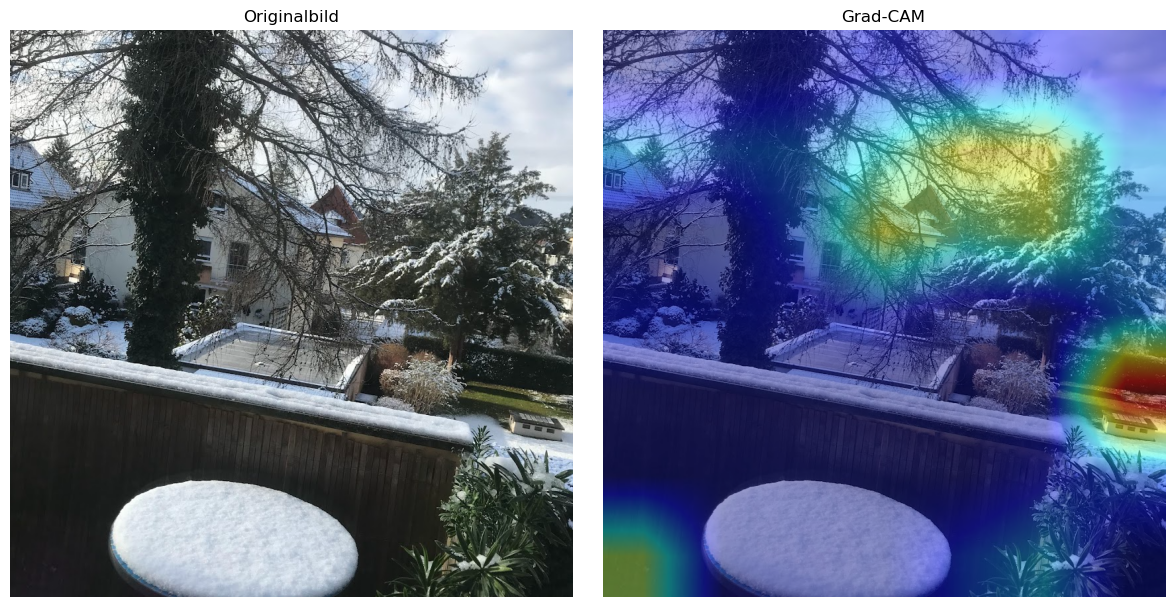

In [31]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2  # OpenCV wird für die Heatmap-Erzeugung verwendet

# --- Pfade anpassen ---
model_path = r"C:\Users\lpera\Downloads\resnet50_places365.pth\resnet50_places365.pth"
categories_file = r"C:\Users\lpera\Downloads\categories_places365.txt"
img_path = r"C:\Users\lpera\OneDrive\Bilder\Screenshots\Screenshot 2025-02-17 124918.png"

# --- Modell definieren und laden ---
# ResNet50 mit 365 Klassen
model = models.resnet50(num_classes=365)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
if "state_dict" in checkpoint:
    state_dict = checkpoint["state_dict"]
else:
    state_dict = checkpoint

# Entferne ggf. den "module."-Präfix (falls im DataParallel-Modus gespeichert)
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.eval()

# --- Kategorien laden ---
with open(categories_file, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# --- Bildvorverarbeitung ---
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
img = Image.open(img_path).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0)  # Batch-Dimension hinzufügen

# --- Variablen zum Speichern von Features und Gradienten ---
features = None
gradients = None

# --- Hook-Funktionen definieren ---
def forward_hook(module, input, output):
    global features
    features = output.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients
    # grad_out ist ein Tuple, wir verwenden das erste Element
    gradients = grad_out[0].detach()

# --- Hooks an der letzten Convolution-Schicht registrieren ---
# Bei ResNet50 ist die letzte Convolution-Schicht typischerweise in model.layer4[-1]
target_layer = model.layer4[-1]
handle_forward = target_layer.register_forward_hook(forward_hook)
handle_backward = target_layer.register_backward_hook(backward_hook)

# --- Vorwärts-Pass und Vorhersage ---
output = model(input_tensor)
pred_probs = F.softmax(output, dim=1).squeeze()
pred_class = pred_probs.argmax().item()
print("Vorhergesagte Klasse: {} ({:.3f})".format(classes[pred_class], pred_probs[pred_class].item()))

# --- Backward-Pass: Setze Gradienten für die vorhergesagte Klasse ---
model.zero_grad()
score = output[0, pred_class]
score.backward()

# --- Grad-CAM berechnen ---
# Berechne Kanalgewichte als globaler Durchschnitt der Gradienten über Höhe und Breite
weights = torch.mean(gradients, dim=[1, 2])  # Shape: [Anzahl Kanäle]

# Berechne die gewichtete Summe der Feature Maps
cam = torch.zeros(features.shape[2:], dtype=torch.float32)  # (H, W)
for i, w in enumerate(weights):
    cam += w * features[0, i, :, :]

# Wende ReLU an (nur positive Werte behalten)
cam = F.relu(cam)

# Normiere die CAM auf den Bereich [0, 1]
cam -= cam.min()
if cam.max() != 0:
    cam /= cam.max()

# --- CAM auf Originalbildgröße skalieren und als Heatmap erzeugen ---
cam_np = cam.cpu().numpy()
cam_np = cv2.resize(cam_np, (img.width, img.height))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Umwandlung von BGR zu RGB

# --- Heatmap als Overlay über das Originalbild legen ---
img_np = np.array(img)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# --- Ergebnisse plotten ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()

# --- Hooks entfernen ---
handle_forward.remove()
handle_backward.remove()


Found 11 files belonging to 5 classes.
Test-Klassen: ['bus', 'subway', 'subway (old)', 'train', 'tram']
Erwartete Eingabeform: [  1 160 160   3]
Vorhergesagte Klassen (Indices): [0 0 1 1 1 2 2 3 3 4 4]
Tatsächliche Labels (Indices): [0 0 1 1 1 2 2 3 3 4 4]
Test Accuracy: 1.0


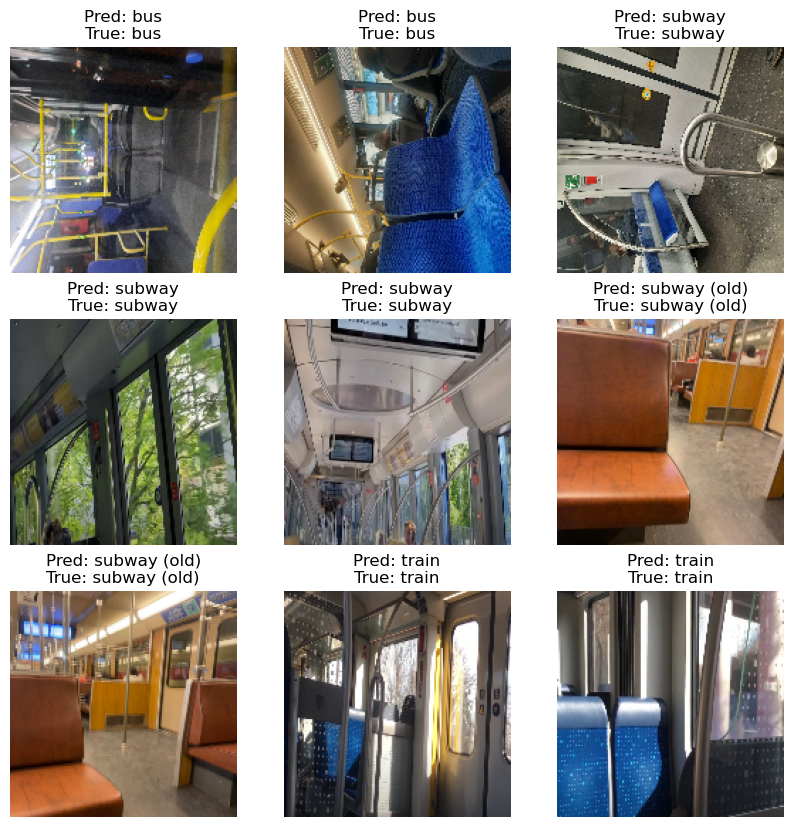

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Pfade und Parameter
TFLITE_MODEL_PATH = r'C:\Users\lpera\model.tflite'
TEST_DATASET_PATH = r'C:\Users\lpera\image_dataset_folder_test'  # Testordner mit Unterordnern "bus", "subway", "train", "tram"
#TEST_DATASET_PATH = r"C:\Users\lpera\Desktop\Uni\AndroidStudioProjects\Airquix01\app\src\main\assets\old_model.tflite"  # Testordner mit Unterordnern "bus", "subway", "train", "tram"

BATCH_SIZE = 1   # Wir setzen Batchgröße 1, da das TFLite-Modell in der Regel Eingaben mit Batch=1 erwartet
IMG_SIZE = (160, 160)

# 1. Test-Datensatz laden
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DATASET_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # Für konsistente Reihenfolge
)
# Die automatisch gelesenen Klassen-Namen (Ordnernamen) aus dem Testset
class_names = test_ds.class_names
print("Test-Klassen:", class_names)

# 2. TFLite-Interpreter initialisieren und Modell laden
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Überprüfe die erwartete Eingabeform (sollte [1, 160, 160, 3] sein)
expected_input_shape = input_details[0]['shape']
print("Erwartete Eingabeform:", expected_input_shape)

# 3. Inferenz über den Test-Datensatz durchführen
all_predictions = []
all_labels = []

for images, labels in test_ds:
    # images hat Shape: (1, 160, 160, 3) (da Batchgröße 1)
    images_np = images.numpy()
    # Setze das Bild in den Interpreter
    interpreter.set_tensor(input_details[0]['index'], images_np)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]['index'])  # preds hat Shape (1, num_classes)
    pred_class = np.argmax(preds[0])
    all_predictions.append(pred_class)
    all_labels.append(labels.numpy()[0])

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("Vorhergesagte Klassen (Indices):", all_predictions)
print("Tatsächliche Labels (Indices):", all_labels)

# Berechne die Testgenauigkeit
accuracy = np.sum(all_predictions == all_labels) / len(all_predictions)
print("Test Accuracy:", accuracy)

# 4. Visualisierung einiger Testbilder mit Vorhersagen
plt.figure(figsize=(10,10))
# Wir visualisieren die ersten 9 Bilder aus dem Testset
i = 0
for images, labels in test_ds.take(9):
    images_np = images.numpy()
    interpreter.set_tensor(input_details[0]['index'], images_np)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]['index'])
    pred_class = np.argmax(preds[0])
    true_class = labels.numpy()[0]
    
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images_np[0].astype("uint8"))
    plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}")
    plt.axis("off")
    i += 1
plt.show()


In [ ]:
import torch
import torchvision.models as models

# Pfad zu deiner .pth-Datei
model_path = r"C:\Users\lpera\alexnet_places365.pth\alexnet_places365.pth"

# Initialisiere das AlexNet-Modell für 365 Klassen (Places365)
model = models.alexnet(weights=None)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 365)

# Lade die vortrainierten Gewichte
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# Eventuell "module." entfernen, falls mit DataParallel trainiert wurde
state_dict = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}

model.load_state_dict(state_dict)
model.eval()

# Konvertiere das Modell zu TorchScript
scripted_model = torch.jit.script(model)

# Speichere das TorchScript-Modell als .pt-Datei
scripted_model.save("alexnet_places365New.pt")

print("Konvertierung erfolgreich abgeschlossen!")
print("Die Datei 'alexnet_places365.pt' wurde erzeugt.")


In [ ]:
#!/usr/bin/env python3
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pfad zur CSV-Datei mit den 5-Sekunden-Outputs der App (kommagetrennt)
CSV_PATH = r"C:\Users\lpera\label_dataset\merged_label_dataset.csv"

def load_and_split_data(csv_path):
    """
    Liest die CSV-Datei ein (mit Komma als Delimiter), entfernt die 'timestamp'-Spalte und
    teilt die Daten stratified in Trainings- und Testdaten auf (80/20).
    """
    # Lese die CSV-Datei mit Komma als Delimiter
    df = pd.read_csv(csv_path, delimiter=",", encoding="utf-8")
    
    # Säubere die Spaltennamen (entfernt etwaige Leerzeichen)
    df.columns = df.columns.str.strip()
    
    # Entferne die "timestamp"-Spalte, falls vorhanden
    if "timestamp" in df.columns:
        df = df.drop(columns=["timestamp"])
        
    # Konvertiere das Label in String und in Kleinbuchstaben
    df["status_gt"] = df["status_gt"].astype(str).str.lower()
    
    # Aufteilen in Trainings- und Testdaten (80% Training, 20% Test) mit stratified split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["status_gt"]
    )
    return train_df, test_df

def get_feature_columns(df):
    """
    Nutzt alle Spalten außer 'status_gt' als Features und unterscheidet numerische von 
    kategorialen Spalten.
    """
    feature_cols = [col for col in df.columns if col != "status_gt"]
    numeric_cols = []
    categorical_cols = []
    for col in feature_cols:
        if df[col].dtype == object:
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)
    return numeric_cols, categorical_cols

def build_preprocessing_model(train_df, numeric_cols, categorical_cols):
    """
    Baut einen Preprocessing-Zweig:
      - Numerische Features werden mit tf.keras.layers.Normalization normalisiert.
      - Kategoriale Features werden mittels StringLookup und One-Hot-Encoding verarbeitet.
    Alle vorverarbeiteten Features werden konkateniert.
    """
    inputs = {}
    encoded_features = []
    
    # Numerische Features: Normalisierung
    for col in numeric_cols:
        inp = tf.keras.Input(shape=(1,), name=col)
        norm = tf.keras.layers.Normalization(name=f"{col}_norm")
        norm.adapt(train_df[[col]].values)
        encoded = norm(inp)
        inputs[col] = inp
        encoded_features.append(encoded)
    
    # Kategoriale Features: StringLookup und One-Hot-Encoding
    for col in categorical_cols:
        inp = tf.keras.Input(shape=(1,), name=col, dtype=tf.string)
        lookup = tf.keras.layers.StringLookup(output_mode='int', name=f"{col}_lookup")
        lookup.adapt(train_df[col].values)
        num_tokens = lookup.vocabulary_size()
        one_hot = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode='one_hot', name=f"{col}_onehot")
        encoded = one_hot(lookup(inp))
        inputs[col] = inp
        encoded_features.append(encoded)
    
    concatenated = tf.keras.layers.Concatenate()(encoded_features)
    return inputs, concatenated

def build_model(feature_vector):
    """
    Baut ein neuronales Netzwerk, das den Status klassifiziert.
    Es enthält Dense-Schichten, BatchNormalization und Dropout, 
    und endet in einer Ausgabeschicht, die 7 Klassen (oder mehr, je nach Mapping) abbildet.
    """
    x = tf.keras.layers.Dense(128, activation='relu')(feature_vector)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Passe hier die Anzahl der Ausgabeneuronen an dein Label-Mapping an.
    output = tf.keras.layers.Dense(7, activation='softmax')(x)
    return output

def df_to_dict(df, feature_cols):
    """
    Wandelt einen DataFrame in ein Dictionary um, das von Keras als Input genutzt werden kann.
    """
    return {col: df[col].values for col in feature_cols}

def main():
    # 1) Daten laden und aufteilen
    train_df, test_df = load_and_split_data(CSV_PATH)
    
    # 2) Ermitteln der Feature-Spalten (numerisch und kategorial)
    numeric_cols, categorical_cols = get_feature_columns(train_df)
    print("Numerische Spalten:", numeric_cols)
    print("Kategoriale Spalten:", categorical_cols)
    
    # 3) Preprocessing-Modell erstellen: Wandelt Rohdaten in einen Feature-Vektor um.
    inputs, concatenated = build_preprocessing_model(train_df, numeric_cols, categorical_cols)
    
    # 4) Modell bauen
    outputs = build_model(concatenated)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 5) Eingabedaten vorbereiten: Verwende alle Spalten außer "status_gt".
    feature_cols = numeric_cols + categorical_cols
    train_features = df_to_dict(train_df, feature_cols)
    test_features = df_to_dict(test_df, feature_cols)
    
    # 6) Label Mapping: Passe das Mapping an deine Klassen an.
    label_mapping = {
        "vehicle in subway": 0,
        "outdoor on foot": 1,
        "indoor in supermarket": 2,
        "vehicle in tram": 3,
        "indoor with window closed": 4,
        "indoor in subway-station": 5,
        "train": 6
    }
    train_labels = train_df["status_gt"].map(label_mapping)
    test_labels = test_df["status_gt"].map(label_mapping)
    
    # Überprüfe unmappte Labels
    if train_labels.isnull().any() or test_labels.isnull().any():
        raise ValueError("Es gibt Labels in 'status_gt', die nicht im Mapping enthalten sind.")
    
    train_labels = train_labels.values
    test_labels = test_labels.values
    
    # 7) Callbacks: EarlyStopping und ModelCheckpoint
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True)
    
    # 8) Training
    history = model.fit(train_features, train_labels,
                        epochs=50,
                        validation_split=0.2,
                        batch_size=32,
                        callbacks=[early_stopping, checkpoint])
    
    # 9) Evaluation
    loss, accuracy = model.evaluate(test_features, test_labels)
    print("Test Accuracy:", accuracy)
    
    # 10) Plot Trainingsverlauf
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 11) Confusion Matrix und Classification Report (normalisiert)
    test_pred = model.predict(test_features)
    test_pred_labels = np.argmax(test_pred, axis=1)
    
    cm = confusion_matrix(test_labels, test_pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion Matrix:")
    print(cm_normalized)
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(label_mapping.keys()),
                yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    #report = classification_report(test_labels, test_pred_labels, target_names=list(label_mapping.keys()))
    #print("Classification Report:")
    #print(report)

        
    # 12) Modell speichern
    model.save("tf_nn_model.keras")

if __name__ == "__main__":
    main()
